<a href="https://colab.research.google.com/github/AntonAIG/photovoltaic_analytics/blob/main/NREL_solar_systems/nrel_pv_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NREL National PV Systems Analytics

Table of contents:
* Introduction
* Data sources
* Data processing
* Exploratory analysis
* Visualization
* Summary


### Introduction
The US National Renewable Energy laboratory (NREL), in colaboration with the Department of Energy's Open Energy Data Initiative (OEDI) carried out an investigation of solar systems in the US. 

> The objective was to perform analysis for evaluating the performance of the solar systems on key metrices such as annual growth of system sizes and customer segmentation.

My role is to carryout this evaluation as outlined above and provide a summarized conclusion and recommendation for further actions. This is provided at the summary and recommendation section of this notebook.

### Data sources
NREL gathered information on about 1 million solar cell systems and recorded system properties and other general information about each system. Some of the features investigated were installation date, system size (DC), total installation price, rebate, customer segment, system phase, tracking technology, city, state, etc, making a total of 81 features.

The data was made available by the [Lawrence Berkeley National Laboratory](https://emp.lbl.gov/tracking-the-sun). The data source is therefore reliable. The dataset covers PV system installations from 1998 - 2020, of mostly residential users. The datasets are in `*csv` format; an initial exploration was done in `sql`. In **sql**, I joined the various datasets to form a single file that will be used for futher evaluation. Null values are represented as `-1`

### Data processing

The dataset will be imported from my drive directory and stored in a dataframe called `nrel`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from collections import Counter
%matplotlib inline

The file was imported here after mounting my drive.
All str: `-1` values are converted to NA.

In [2]:
nrel = pd.read_csv("/content/drive/MyDrive/Project Portfolio/DA_Solar Panel PV Syst/TTS_LBNL_public_file_27-Jan-2022_p1.csv",
                   index_col='PTODate_orProxy_', na_values='-1', parse_dates=['PTODate_orProxy_'])
nrel.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,14,15,17,19,27,28,30,31,33,34,37,38,39,52,53,55,56,58,59,76,77,78) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,dataProvider1,dataProvider2,program1ProjectID,program2ProjectID,systemSizeInDCSTC_KW_,totalInstalledCost___,Up_FrontCashIncentive___,customerSegment,is_expansion,is_multiphase,newConstruction_Y_N_,tracking_Y_N_,ground_mounted_Y_N_,hostCustomerZip__4_,hostCustomerCity,state,utilityServiceTerritory,x3rdPartyOwned_1_0_,installer_clean,self_install_Y_N_,azimuth_1,azimuth_2,azimuth_3,tilt_1,tilt_2,tilt_3,mod_manuf1_clean,mod_model1_clean,moduleQty_1,mod_manuf2_clean,mod_model2_clean,moduleQty_2,mod_manuf3_clean,mod_model3_clean,moduleQty_3,additionalModuleModels_Y_N_,mod_tech1,mod_tech2,mod_tech3,mod_BIPV1,mod_BIPV2,mod_BIPV3,mod_bifacial1,mod_bifacial2,mod_bifacial3,mod_nameplate_capacity1,mod_nameplate_capacity2,mod_nameplate_capacity3,mod_efficiency1,mod_efficiency2,mod_efficiency3,inv_manuf1_clean,inv_model1_clean,inverterQuantity_1,inv_manuf2_clean,inv_model2_clean,inverterQuantity_2,inv_manuf3_clean,inv_model3_clean,inverterQuantity_3,additionalInverterModels_Y_N_,inv_microinv1,inv_microinv2,inv_microinv3,inv_battery_hybrid1,inv_battery_hybrid2,inv_battery_hybrid3,inv_builtin_meter1,inv_builtin_meter2,inv_builtin_meter3,inv_outputcapacity1,inv_outputcapacity2,inv_outputcapacity3,dc_optimizer,ILR,dateOfBatteryInstall,batteryManufacturer_clean,batteryModel_clean,batteryKW,batteryKWh
PTODate_orProxy_,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30-Dec-2011,Arizona Public Service,NaN,1,NaN,18000.000,NaN,NaN,NON-RES,0,0,NaN,NaN,NaN,86321.0,Bagdad,AZ,Arizona Public Service,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Advanced Energy Industries,Solaron 500kW (3159500-XXXX),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,500.000,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
22-Dec-1995,Arizona Public Service,NaN,2,NaN,NaN,NaN,NaN,RES,0,0,NaN,NaN,NaN,85262.0,Scottsdale,AZ,Arizona Public Service,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Siemens Industry,SINVERT PVS1401 UL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,1400.000,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
24-Jan-2000,Arizona Public Service,NaN,3,NaN,12.025,NaN,NaN,RES,0,0,NaN,NaN,NaN,85338.0,Goodyear,AZ,Arizona Public Service,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Hanwha Q CELLS,Q.PEAK DUO-G7 325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mono,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,325.0,NaN,NaN,0.199387,NaN,NaN,Enphase Energy,IQ7-60-2-US [240V],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.240,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
02-Feb-2000,Arizona Public Service,NaN,4,NaN,NaN,NaN,NaN,RES,0,0,NaN,NaN,NaN,85320.0,Aguila,AZ,Arizona Public Service,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Siemens Industry,SINVERT PVS1401 UL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,1400.000,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
06-Mar-2000,Arizona Public Service,NaN,5,NaN,8.640,NaN,NaN,RES,0,0,NaN,NaN,NaN,85396.0,Buckeye,AZ,Arizona Public Service,0.0,Titan Solar,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Silfab Solar Inc.,SIL-320NL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mono,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,320.0,NaN,NaN,0.196262,NaN,NaN,SolarEdge Technologies,SE7600H-US [240V],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,7.616,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


The *PTODate_orProxy_* was parsed as datetime to the index. Binary answers are presented in 0,1 = N,Y formats

An info into the data types is shown bellow

In [97]:
nrel.describe()

,systemSizeInDCSTC_KW_,totalInstalledCost___,Up_FrontCashIncentive___,is_expansion,is_multiphase,newConstruction_Y_N_,tracking_Y_N_,ground_mounted_Y_N_,x3rdPartyOwned_1_0_,self_install_Y_N_,azimuth_1,azimuth_2,azimuth_3,tilt_1,tilt_2,tilt_3,moduleQty_1,moduleQty_2,moduleQty_3,additionalModuleModels_Y_N_,mod_BIPV1,mod_BIPV2,mod_BIPV3,mod_bifacial1,mod_bifacial2,mod_bifacial3,mod_nameplate_capacity1,mod_nameplate_capacity2,mod_nameplate_capacity3,mod_efficiency1,mod_efficiency2,mod_efficiency3,inverterQuantity_1,inverterQuantity_2,inverterQuantity_3,additionalInverterModels_Y_N_,inv_microinv1,inv_microinv2,inv_microinv3,inv_battery_hybrid1,inv_battery_hybrid2,inv_battery_hybrid3,inv_builtin_meter1,inv_builtin_meter2,inv_builtin_meter3,inv_outputcapacity1,inv_outputcapacity2,inv_outputcapacity3,dc_optimizer,ILR,batteryKW,batteryKWh
count,9.951220e+05,6.943840e+05,7.462760e+05,1000000.000000,1000000.000000,80032.000000,362239.000000,277651.000000,816926.000000,841468.000000,323586.000000,52682.000000,19240.000000,323492.000000,52683.000000,19240.000000,495814.000000,62648.000000,21303.000000,368514.000000,614803.000000,63207.000000,21534.000000,615763.000000,63223.000000,21537.000000,615674.000000,63219.000000,21536.000000,612669.000000,63048.000000,21502.000000,476050.000000,19456.000000,2634.000000,363516.000000,614180.000000,22238.000000,3663.000000,503918.000000,16104.000000,2087.000000,614180.000000,22238.000000,3663.000000,607045.000000,21891.000000,3659.000000,635256.000000,429508.000000,5365.000000,5127.000000
mean,2.298073e+01,5.459592e+04,4.928671e+03,0.016551,0.005362,0.111405,0.006907,0.038710,0.502301,0.005414,185.154815,182.802912,180.941580,23.906163,24.625458,24.654938,56.380857,22.370451,16.196310,0.020089,0.002188,0.000886,0.000511,0.001895,0.000475,0.000464,293.185204,291.379926,293.904014,0.179199,0.179262,0.180525,8.692073,4.816612,6.123766,0.002611,0.298777,0.250562,0.460278,0.042896,0.019933,0.007187,0.584299,0.541191,0.393393,7.007147,8.545457,6.403947,0.380066,1.140338,18.511447,42.242603
std,1.514154e+03,5.838126e+05,5.852499e+04,0.127582,0.073029,0.314636,0.082821,0.192904,0.499995,0.073383,56.160129,77.333003,80.336393,9.301603,9.434753,9.688039,1019.500679,250.382858,171.128225,0.140304,0.046722,0.029752,0.022596,0.043493,0.021778,0.021544,44.370096,38.277520,37.194998,0.022027,0.020212,0.019938,30.990639,45.088313,7.065094,0.051028,0.457722,0.433346,0.498488,0.202623,0.139774,0.084493,0.492843,0.498312,0.488570,56.270172,47.777217,38.682001,0.485403,0.137604,151.728180,330.302935
min,3.150000e-03,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,12.000000,12.000000,0.054687,0.059649,0.059649,0.042361,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.175000,0.175000,0.190000,0.000000,0.750000,0.280000,0.840000
25%,4.880000e+00,1.921920e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,160.000000,119.000000,110.000000,18.000000,18.000000,18.000000,14.000000,6.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,260.000000,260.000000,260.000000,0.160714,0.161417,0.163847,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.315000,0.380000,0.215000,0.000000,1.047619,5.000000,9.800000
50%,6.900000e+00,2.745600e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,180.000000,180.000000,180.000000,23.000000,23.000000,23.000000,20.000000,10.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,300.000000,290.000000,295.000000,0.180380,0.176647,0.180998,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,4.600000,3.800000,2.9620

The data shows that the average cost of installation is `$54,838.12`. With an average system size of 22.98kW, cost per kW is $2,386.34/kW.

Certain observations (rows/project) has no date. Since date is the primary feature, those observations will be eliminated.

In [4]:
nrel_t = pd.to_datetime(nrel.index, errors='coerce')

In [5]:
len(list(nrel_t.isna()))

1000000

In [6]:
dt = list(nrel_t.isna()) # list of booleans
not_a_date = []

for point in range(len(dt)):
  if dt[point] == True:
    not_a_date.append(point)
  point+=1

In [7]:
is_a_date = set(range(nrel.shape[0])) - set(not_a_date)
nrel_df = nrel.take(list(is_a_date))
nrel_df.shape

(984635, 80)

A certain analytic step might be to remove the columns containing more than 10% null value for instance. Or remove all null values.

Since we are not carrying out column-to-column calculations, we can ignore the presence of null values. However, I considered columns that contain more than 25% null values to be biased and therefore had to remove them from the analysis. If a particular feature that should be present in each PV system was not recorded and that feature has more than 30% missing value, then we can say that it is biased.


In [8]:
nrel_cols = nrel_df.columns
nrel_selected = []

for col in nrel_cols:
  cols = nrel_df[col]
  na_val = cols.isnull().sum()
  na_perc = (na_val/(nrel_df.shape[0]))*100
  if na_perc < 25:
    nrel_selected.append(col)

# specially needed for visualization of module efficiency
nrel_selected.append('mod_efficiency1')
len(nrel_selected)

19

In [9]:
nrel_df = nrel_df[nrel_selected]

### Exploratory analysis

Here we can preview the summary statistics of the new dataset.

In [10]:
nrel_df.describe()

,systemSizeInDCSTC_KW_,is_expansion,is_multiphase,x3rdPartyOwned_1_0_,self_install_Y_N_,mod_efficiency1
count,982374.000000,984635.000000,984635.000000,810160.000000,826828.000000,604203.000000
mean,17.539679,0.016791,0.005446,0.504308,0.005365,0.179097
std,555.319059,0.128488,0.073594,0.499982,0.073050,0.021933
min,0.003150,0.000000,0.000000,0.000000,0.000000,0.054687
25%,4.880000,0.000000,0.000000,0.000000,0.000000,0.160696
50%,6.890000,0.000000,0.000000,1.000000,0.000000,0.180380
75%,9.600000,0.000000,0.000000,1.000000,0.000000,0.197531
max,424000.000000,1.000000,1.000000,1.000000,1.000000,0.227545


In [11]:
nrel_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 984635 entries, 30-Dec-2011 to 05-Mar-2020
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   dataProvider1            984635 non-null  object 
 1   program1ProjectID        922739 non-null  object 
 2   systemSizeInDCSTC_KW_    982374 non-null  float64
 3   customerSegment          961207 non-null  object 
 4   is_expansion             984635 non-null  int64  
 5   is_multiphase            984635 non-null  int64  
 6   hostCustomerZip__4_      895723 non-null  object 
 7   hostCustomerCity         838244 non-null  object 
 8   state                    984635 non-null  object 
 9   utilityServiceTerritory  911833 non-null  object 
 10  x3rdPartyOwned_1_0_      810160 non-null  float64
 11  installer_clean          882753 non-null  object 
 12  self_install_Y_N_        826828 non-null  float64
 13  mod_manuf1_clean         741359 non-null  object 

Let's add a column of year to the dataframe.

In [12]:
nrel_df['year'] = pd.DatetimeIndex(nrel_df.index).year

### Vizualizations

The core component of this analysis is to visualize relationships, trends and parterns in the data. Then, we can use those information to answere the business questions proposed.

##### Sample size

We want to know how many Projects were completed every year, using a bar chart.

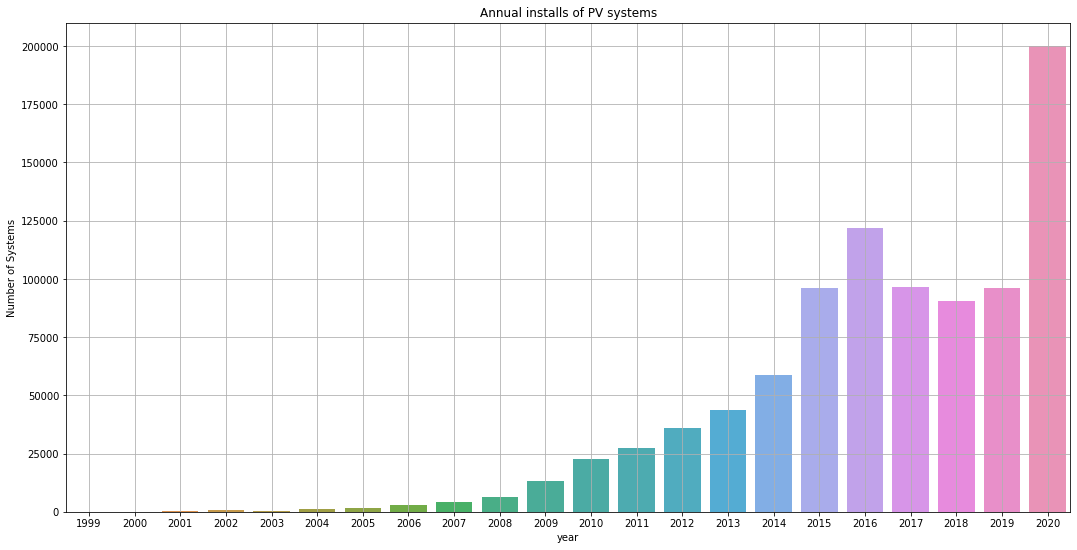

In [13]:
project_n = nrel_df[['program1ProjectID', 'year']]
no_sample = project_n.groupby('year').count()
no_sample = no_sample.iloc[20:42] #1999 - 2020

fig, ax= plt.subplots(figsize=(18,9))
sns.barplot(x=no_sample.index, y="program1ProjectID", data=no_sample)
ax.set_ylabel("Number of Systems")
ax.set_title("Annual installs of PV systems")
ax.grid()

This image shows the annual increase in number of installations of solar power. But there is a decline in 2015 - 2019, and then a sharp growth in 2020.

Next we can find out the precentage contribution of the ten largest states to the total amount of residential and non-residential installations respectively.

Since we'll be working a lot more with subgroups of customer segments, it will be wise to split the dataframe into a dictionary of dataframes for each unique values in customer segments.

In [14]:
nrel_split = dict(tuple(nrel_df.groupby('customerSegment')))
res_split = nrel_split['RES']
com_split = nrel_split['COM']
non_res_split = nrel_split['NON-RES']
non_profit_split = nrel_split['NON-PROFIT']
school_split = nrel_split['SCHOOL']
gov_split = nrel_split['GOV']

Disribution of the number of projects accross:
* Customer Segments
* States

In [15]:
states_contribution = nrel_df[['dataProvider1','customerSegment','state']]
customer_seg = states_contribution.groupby(['customerSegment'])['dataProvider1'].count().reset_index(
    name='count').sort_values(['count'], ascending=False)
states = states_contribution.groupby(['state'])['dataProvider1'].count().reset_index(
    name='count').sort_values(['count'], ascending=False)

Text(0, 0.5, 'Number of Projects')

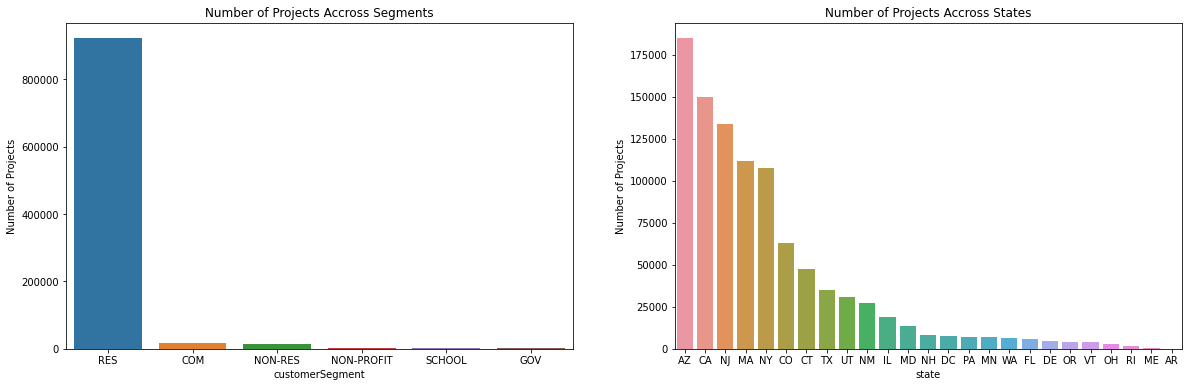

In [16]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.barplot(x='customerSegment', y='count', data=customer_seg, ax=ax[0])
ax[0].set_title('Number of Projects Accross Segments')
ax[0].set_ylabel('Number of Projects')
sns.barplot(x='state', y='count', data=states, ax=ax[1])
ax[1].set_title('Number of Projects Accross States')
ax[1].set_ylabel('Number of Projects')

In the images above, we can see the number of projects accros the customer segments and state. Residential (RES) is the most common installations followed by commercial (COM) installations.

Next we can find out the percentage contribution of the states for RES and NON-RES

In [30]:
res_split_state = res_split[['state', 'dataProvider1']].groupby('state').count().sort_values(['dataProvider1'], ascending=False)
non_res_split_state = non_res_split[['state', 'dataProvider1']].groupby('state').count().sort_values(['dataProvider1'], ascending=False)

In [50]:
res_df_upper = res_split_state.head(9)
res_df_lower = res_split_state.tail(15).sum()
res_df_upper.loc['others'] = [int(res_df_lower)]

non_res_df_upper =non_res_split_state.head(9)
non_res_df_lower = non_res_split_state.tail(9).sum()
non_res_df_upper.loc['others'] = [int(non_res_df_lower)]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


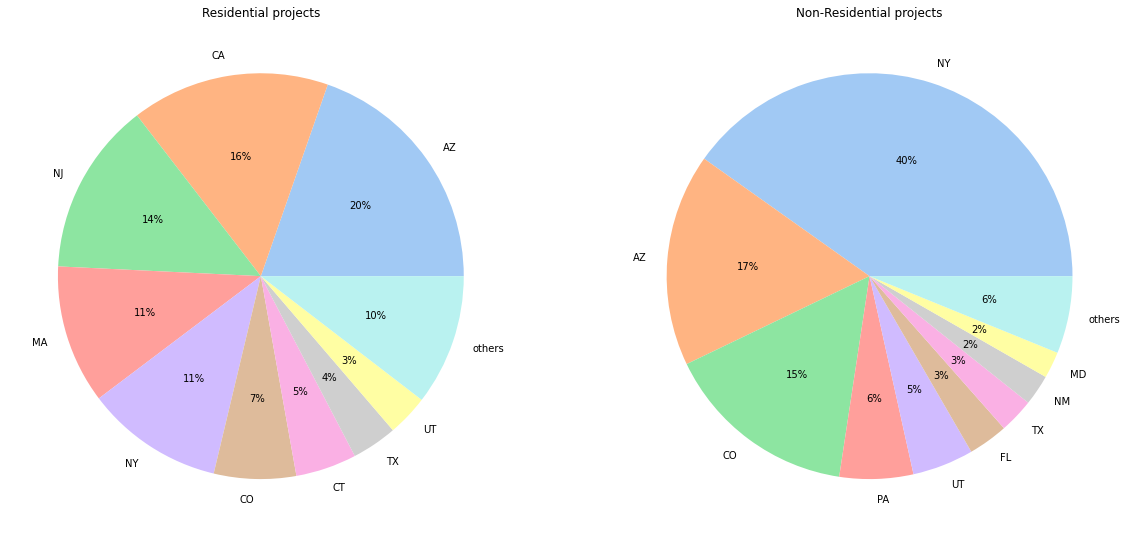

In [54]:
fig, ax = plt.subplots(1,2, figsize=(20,14))
colors = sns.color_palette('pastel')
ax[0].pie(res_df_upper['dataProvider1'], labels=res_df_upper.index, colors=colors, autopct='%.0f%%')
ax[1].pie(non_res_df_upper['dataProvider1'], labels=non_res_df_upper.index, colors=colors, autopct='%.0f%%')
ax[0].set_title('Residential projects')
ax[1].set_title('Non-Residential projects')
plt.show()

##### System Size
Let's have a look at the systems sizes (kWp) and efficiency for customer segements with respect to:
* annual trends and
* module technology

In [95]:
res_split_year = res_split[['year','systemSizeInDCSTC_KW_']].groupby('year').mean()
non_res_split_year = non_res_split[['year','systemSizeInDCSTC_KW_']].groupby('year').mean()
list(non_res_split_year.index).index(2020)

22

Text(0.5, 1.0, 'Non-Residential system size')

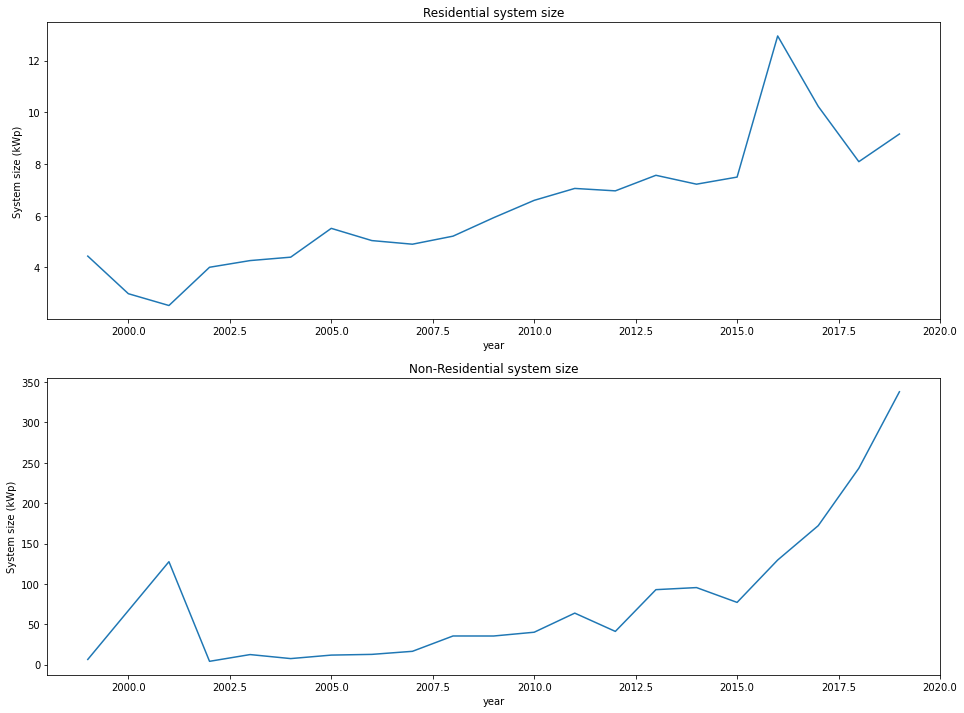

In [96]:
res_split_year = res_split_year.iloc[16:37]
non_res_split_year = non_res_split_year.iloc[1:22]
fig, ax = plt.subplots(2,1, figsize=(16,12))
sns.lineplot(data=res_split_year, x=res_split_year.index, y='systemSizeInDCSTC_KW_', ax=ax[0])
sns.lineplot(data=non_res_split_year, x=non_res_split_year.index, y='systemSizeInDCSTC_KW_', ax=ax[1])
ax[0].set_ylabel('System size (kWp)')
ax[1].set_ylabel('System size (kWp)')
ax[0].set_title('Residential system size')
ax[1].set_title('Non-Residential system size')

The system sizes have increased gradually for both the residential and non-residiential customer segements.

### Summary

In this project, we found out that:

* There is a steady increase in the implementation of residential and non-residential systems along the years. This can also be seen from the increase in the number of projects, which means that more people are adopting PV as an alternitive means of geting power
* The top 3 states in the non-residential customer segment makes up 72% of the projects while the top 3 states in the residential customer segment makes up 51%. This slighly shows the lesser attention paid towards non-residential development.

I would recommend that more non-residential projects should be developed in the future because of the potential for growth. They generally have higher capacity as seen in the image above, and this could translate to higher revenue and lower price/kWp generated.